In [1]:
# author: Francisco J. Guerrero-Gonzalez (f.guerrero@tum.de)
# reviewer: Francisco J. Guerrero-Gonzalez
# version: 1.0.0

Copyright 2023, Professorship of Lunar and Planetary Exploration, Technical University of Munich.

Permission is hereby granted, free of charge, to any person obtaining a copy of this model and associated documentation files, without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the models, and to permit persons to whom the model is furnished to do so, subject to the following conditions:

1. The above copyright notice and this permission notice shall be included in all copies or substantial portions of the model, as well as reference to the author(s) listed above. Scientific publications which use this model shall cite the [ISRULib documentation site](https://wiki.tum.de/display/lpe/ISRULib) attributing credit to the named authors in the documentation.

2. The model is provided without warranty of any kind, express or implied, including but not limited to the warranties of merchantability, fitness for a particular purpose, and non-infringement. In no event shall the authors or copyright holders be liable for any claim, damages, or other liability, whether in an action of contract, tort, or otherwise, arising from, out of, or in connection with the model or the use or other dealings in the model.

# PEM Electrolyzer

In [2]:
# Python Libraries
import numpy as np
from IPython import display

**Model Description**

A Proton Exchange Membrane or Polymer Electrolyte Membrane (PEM) electrolyzer uses electric power to dissociate liquid water into oxygen and hydrogen:

$H_2O \longrightarrow H_2 + \dfrac{1}{2} O_2$

Water is transported to the electrolysis stack, where it is split into oxygen and hydrogen. The hydrogen permeates through the electrolyte inside the stack’s cells, together with small amounts of oxygen, which recombines to water. The generated oxygen together with the non-processed water is transported back to the buffer tank, where the liquid water is separated from the oxygen gas. On the hydrogen side pressure and temperature are high and both hydrogen and water are in a gaseous
state. The small amounts of water vapor, could be removed in a drying unit to provide pure hydrogen for ISRU applications.

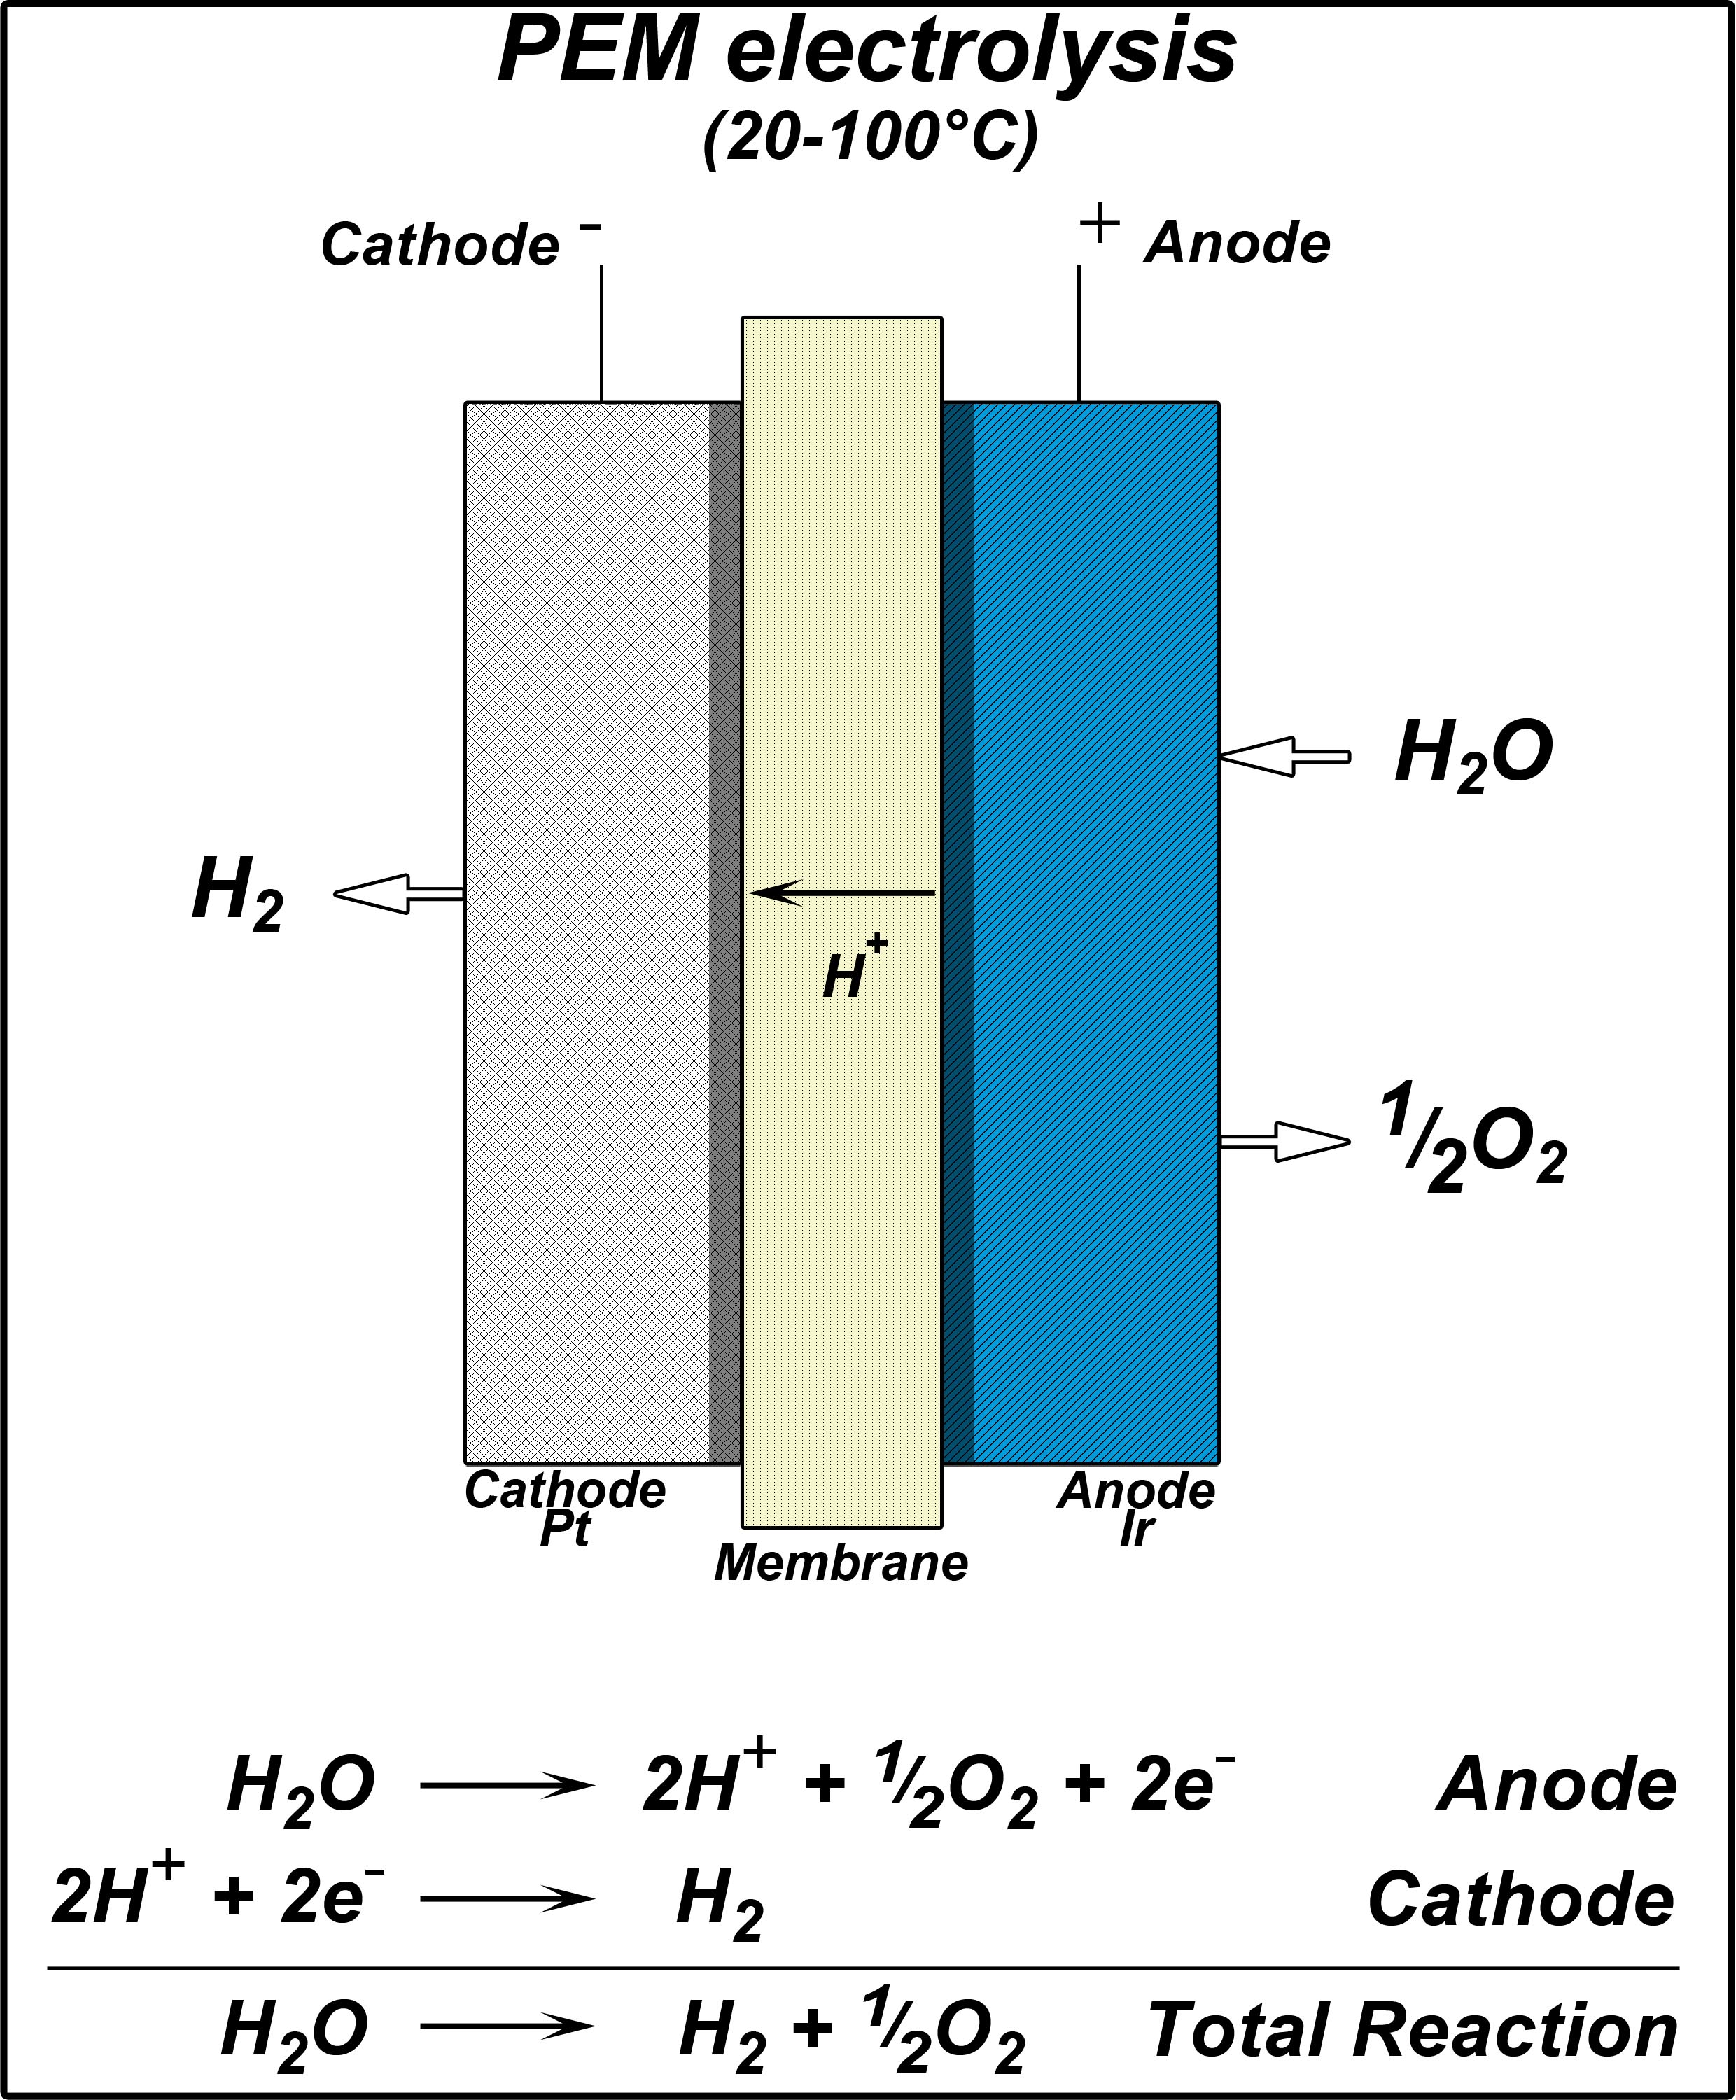

In [61]:
# Include here a descriptive figure of the component (model)
display.Image("figs/PEMelectrolysis.jpg")

**Model Assumptions, Simplifications and future Improvements**

The model calculates the power consumption based on the Gibbs Free Energy ($\Delta{}G$) at 25 ºC:

$\Delta{}G = \Delta{}H - T\cdot\Delta{}S$

where $\Delta{}H$ is the enthalpy of formation and $T\cdot\Delta{}S$ the endothermic heat that must be supplied for the reaction to take place. An overall efficiency is assumed for the power consumption ($\frac{\dot{m}_{H_2O}\cdot\Delta{}G}{\eta_{electrolysis}}$). The endothermic heat is supplied by Joule heating from the power losses ($1-\eta_{electrolysis}$). The remaining heat must be cooled down.

The electrolyzer mass is estimated based on the work of Schrenk (2015). It must be noted that this electrolyzer model only accounts for the electrolysis stack. Other components, such as pumps, driers, water tanks or separators must be included for a better accuracy (see Schrenk, 2015). 

Future improvements could include:
- Better validating the PEM electrolysis overall efficiency with state-of-the-art technologies.
- Improving the electrolyzer mass estimation and comparing it with actual hardware as done by Schrenk (2015).
- Sizing the electrolyzer case thickness dynamically for, e.g., an internal pressure of e.g. 3 MPa.

## 1. Inputs

In [33]:
water_inflow = 9 # kg/h | H2O flow entering the electrolyzer

## 2. Constants

In [52]:
pi = np.pi # -

mH2O = 18 # g/mol | Water molar mass
H2O_delta_G = -237.13e3 # J/mol | Gibbs free energy of water electrolysis (H2O -> H2 + 0.5O2) under standard conditions. Obtained from the internet
H2O_delta_H = -285.83e3 # J/mol | Enthalpy of formation of water electrolysis (H2O -> H2 + 0.5O2) under standard conditions. Obtained from the internet

electrolysis_eff = 0.8 # - | PEM electrolysis overall efficiency. Rough estimation

V_cell = 1.7 # V | Cell voltage (Schrenk, 2015)
i_dens = 25e3 # A/m2 | Current density (Schrenk, 2015)
A_cell = pi*0.09**2 # m2 | Cell area for a cell radius of 9 cm (Schrenk, 2015)

rhoTi = 4000 # kg/m3 | Density of cell material, mainly titanium alloy (Schrenk, 2015)
rhoMembrane = 0.5 # kg/m2 | Density of cell membrane (Schrenk, 2015)
rhoCase = 2000 # kg/m3 | Density of the ceramic material for the case (Schrenk, 2015)

tCell = 6.7e-3 # m | Individual cell thickness (see Schrenk, (2015) for a detailed explanation on the calculation)
tCase = 0.005 # m | Case wall thickness. Rough estimation (Can be sized for an internal pressure of e.g. 3 MPa)

## 3. Model Body

In [55]:
electrolysis_power = -water_inflow*1e3*H2O_delta_G/3600/mH2O/electrolysis_eff # W | PEM power consumption
endothermic_power  = water_inflow*1e3*(H2O_delta_H-H2O_delta_G)/3600/mH2O # W | Endothermic power (heat) required to drive the electrlysis reaction
cooling_power      = electrolysis_power*(1-electrolysis_eff) + endothermic_power # W | Heat produced

# Mass estimation
n_stacks = electrolysis_power/(V_cell*i_dens*A_cell) # - | Number of stack elements (cells) (Schrenk, 2015)
m_cell = A_cell*(0.004*rhoTi + 0.0024*rhoTi*0.6 + rhoMembrane) # kg | Mass of a cell (Schrenk, 2015)
stack_mass = n_stacks*m_cell # kg | Stack (cells) mass (Schrenk, 2015)
# The stack geometry is the following: 1 cell height, n cells circular surface  
stack_height = n_stacks*tCell # m | Stack height (Schrenk, 2015)
rStack = np.sqrt(A_cell*n_stacks/pi)/0.9069 # m | Stack radius
#The stack radius is calculated assuming that all the cells are packed with a density of 0.9069 (See https://en.wikipedia.org/wiki/Circle_packing for densenst packing)
case_mass = rhoCase*pi*(2*(rStack+tCase)*pi*tCase + (2*rStack*tCase + tCase**2)*stack_height) # kg | Case mass (Schrenk, 2015)
electrolyzer_mass = case_mass + stack_mass # kg

## 4. Outputs

In [60]:
print("Mass:    %.2f kg"%(electrolyzer_mass))
print("Power:   %.2f kW"%(electrolysis_power/1e3))
print("Cooling: %.2f kW"%(cooling_power/1e3))

Mass:    153.26 kg
Power:   41.17 kW
Cooling: 1.47 kW


## References

L. Schrenk, Development of an In-Situ Resource Utilization (ISRU) Module for the Mission Analysis Environment HabNet (Master’s thesis), Technical University of Munich, 2015